In [13]:
# The computation time for the translation part is really long, so we did it and save the new version
# of our dataframe in a csv in which we are going to work.

import pandas as pd
from googletrans import Translator # pip install googletrans==3.1.0a0
from tqdm import tqdm

# Importing the dataframe
# df = pd.read_csv('data_tweet_sample_challenge.csv')  
  
# =============================================================================
# Translate the tweets in English
# =============================================================================
# tr = Translator()

# Creating a progression bar
# progress_bar = tqdm(total=len(df), desc="Translation Progress")

# for i, row in df.iterrows():
    #if row["label"] != "en":
        #translated_text = tr.translate(row["text"], dest='en').text
        #df.at[i, "text"] = translated_text

    # Updating the progression bar
    #progress_bar.update(1)

#progress_bar.close()

# Saving in a csv file
#csv_file_path = 'clean_data_tweet_sample.csv'
#df.to_csv(csv_file_path, index=False)

In [14]:
import pandas as pd
import re
import nltk.corpus 
nltk.download('stopwords')
from nltk.corpus import stopwords
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
from tqdm import tqdm
from transformers import pipeline

warnings.filterwarnings("ignore")

# Importing the dataframe
df = pd.read_csv('clean_data_tweet_sample.csv')  

[nltk_data] Downloading package stopwords to /Users/lyna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# =============================================================================
# Extracting the hashtags and links
# =============================================================================
def extract_tags(text:str)->dict(): 
    d = {}
    try:
        tags = re.findall(r'#\w+',text)
        d['hash_tags'] = tags
    except: 
        d['hash_tags'] = []
    try:
        d['links'] = re.findall(r'(https://t.co/\w+|http://t.co/\w+)',text)
        for link in d['links']:
            text = text.replace(link,'')
    except:
        d['links'] = []
    
    try:
        for tag in tags:
            text = text.replace(tag,'')
        text = text.strip()
        d['text'] = text
    except:
        d['text'] = text
    
    return d
    

extract_tags(df['text'][3])

def clean_text_col(df):
    text = list()
    links = list()
    tags = list()
    d_clean = dict()
    for r in range(0,len(df)):
        text.append(extract_tags(df['text'][r])['text'])
        tags.append(extract_tags(df['text'][r])['hash_tags'])
        links.append(extract_tags(df['text'][r])['links'])
    
    df['links'] = links
    df['hash_tags'] = tags        
    return df 

df = clean_text_col(df)

In [16]:
# =============================================================================
# Cleaning the data
# =============================================================================
stop = stopwords.words('english')
stop.append('rt')

def cleaning(text):
    text = text.lower() # putting the text in lowercase
    text = re.sub("\[.*?\]","",text) # Remove text enclosed in square brackets
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    # remove @, non-alphanumeric chars, tabs, url, rt and http
    text = " ".join([word for word in text.split() if word not in (stop)]) # remove stopwords
    return text

df['text'] = df['text'].apply(lambda x: cleaning(x))

df = df.drop_duplicates('text') # drop the duplicates

# Selecting only the columns that we interested in
selected_columns = ['id', 'created_at', 'text', 'author.name', 'label', 'public_metrics.like_count', 'public_metrics.retweet_count', 'links', 'hash_tags']
df = df.loc[:, selected_columns]
df = df.reset_index(inplace = False)

In [17]:
# =============================================================================
# Data visualisation
# =============================================================================

# Create a new column with the date in format: YYYY-MM
df['date_M'] = df['created_at'].apply(lambda x: x[:7])

fig = px.line(df.groupby('date_M').count(), 
              y=df.groupby('date_M').count()['author.name'].values, 
              x=df.groupby('date_M').count().index)
fig.update_layout(plot_bgcolor = "white")
fig.update_layout(
    title="Number of Tweets per months",
    xaxis_title="",
    yaxis_title="Number of Tweets",
    font=dict(
         size=12,
        color="Black"
    ),
    plot_bgcolor = "white"
)
fig.show()

In [18]:
# Plot of the number of tweets per month
fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'en'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'en'].groupby('date_M').count()['author.name'].values,
            name='England'),
    row=1, col=1
)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'es'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'es'].groupby('date_M').count()['author.name'].values,
            name='Spain'),
    row=1, col=2
)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'de'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'de'].groupby('date_M').count()['author.name'].values,
            name='Germany'),
    row=1, col=3
)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'nl'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'nl'].groupby('date_M').count()['author.name'].values,
            name='Netherlands'),
    row=2, col=1
)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'fr'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'fr'].groupby('date_M').count()['author.name'].values,
            name='France'),
    row=2, col=2
)

fig.add_trace(
    go.Line(x=df.loc[df['label'] == 'it'].groupby('date_M').count().index, 
            y=df.loc[df['label'] == 'it'].groupby('date_M').count()['author.name'].values,
            name='Italy'),
    row=2, col=3
)

fig.update_layout(height=600, width=800, title_text="Number of Tweets per months")
fig.show()

In [19]:
# Number of tweets per author
fig = px.bar(df.groupby('author.name').count().sort_values(by='id', ascending=False).head(20), 
              y=df.groupby('author.name').count().sort_values(by='id', ascending=False).head(20)['id'].values, 
              x=df.groupby('author.name').count().sort_values(by='id', ascending=False).head(20).index)
fig.update_layout(plot_bgcolor = "white")
fig.update_layout(
    title="Number of Tweets per author (top 20)",
    xaxis_title="",
    yaxis_title="Number of Tweets",
    font=dict(
         size=12,
        color="Black"
    ),
    plot_bgcolor = "white"
)
fig.show()

In [20]:
# Top 5 per country
fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'en'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'en'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='England'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'es'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'es'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='Spain'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'de'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'de'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='Germany'),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'nl'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'nl'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='Netherlands'),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'fr'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'fr'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='France'),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'it'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'it'].groupby('author.name').count().sort_values(by='id', ascending=False).head(5)['id'].values,
            name='Italy'),
    row=2, col=3
)

fig.update_layout(height=600, width=800, title_text="Number of Tweets per author (top 5)")
fig.show()


In [21]:
# Number of likes per author
fig = px.bar(df.groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(20), 
              y=df.groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(20).values, 
              x=df.groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(20).index)
fig.update_layout(plot_bgcolor = "white")
fig.update_layout(
    title="Total number of likes per author (top 20)",
    xaxis_title="",
    yaxis_title="Total number of likes",
    font=dict(
         size=12,
        color="Black"
    ),
    plot_bgcolor = "white"
)
fig.show()

In [22]:
# Top 5 per country
fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'en'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'en'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='England'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'es'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'es'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='Spain'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'de'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'de'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='Germany'),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'nl'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'nl'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='Netherlands'),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'fr'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'fr'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='France'),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'it'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'it'].groupby('author.name')['public_metrics.like_count'].sum().sort_values(ascending=False).head(5).values,
            name='Italy'),
    row=2, col=3
)

fig.update_layout(height=600, width=800, title_text="Total number of likes per author (top 5)")
fig.show()


In [23]:
# Total retweets per author
fig = px.bar(df.groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(20), 
              y=df.groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(20).values, 
              x=df.groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(20).index)
fig.update_layout(plot_bgcolor = "white")
fig.update_layout(
    title="Total number of retweets per author (top 20)",
    xaxis_title="",
    yaxis_title="Total number of retweets",
    font=dict(
         size=12,
        color="Black"
    ),
    plot_bgcolor = "white"
)
fig.show()

In [24]:
# Top 5 per country
fig = make_subplots(rows=2, cols=3)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'en'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'en'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='England'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'es'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'es'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='Spain'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'de'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'de'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='Germany'),
    row=1, col=3
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'nl'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'nl'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='Netherlands'),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'fr'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'fr'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='France'),
    row=2, col=2
)

fig.add_trace(
    go.Bar(x=df.loc[df['label'] == 'it'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).index, 
            y=df.loc[df['label'] == 'it'].groupby('author.name')['public_metrics.retweet_count'].sum().sort_values(ascending=False).head(5).values,
            name='Italy'),
    row=2, col=3
)

fig.update_layout(height=600, width=800, title_text="Total number of retweets per author (top 5)")
fig.show()


In [25]:
# =============================================================================
# Named Entity Recognition
# =============================================================================

tqdm.pandas()
pipe = pipeline("token-classification", model="autoevaluate/entity-extraction")

# Extract in the dict the keys and values that we interested in
def extract_entity_info(entities):
    return [{'entity': entity['entity'], 'score': entity['score'], 'word': entity['word']} for entity in entities]

# Apply the function in the dataset
df['Entity_recognition'] = df['text'].progress_apply(lambda x: extract_entity_info(pipe(x)))


# Plot the 5 most frequent entities by type of entity
import pandas as pd
import matplotlib.pyplot as plt

# Filter the entities : keep only 'LOC', 'ORG', et 'PER' and a score > 0.90
filtered_entities = df[df['Entity_recognition'].apply(
    lambda x: any(entity['entity'] in ['B-LOC', 'I-LOC', 'B-ORG', 'I-ORG'] and entity['score'] > 0.85 for entity in x)
)]

# Count the frequence by entities
categories = {'LOC': [], 'ORG': []}
word_count = {category: {} for category in categories}
for entities in filtered_entities['Entity_recognition']:
    for entity in entities:
        entity_type = entity['entity']
        if entity_type in ['B-LOC', 'I-LOC', 'B-ORG', 'I-ORG']:
            category = entity_type[2:]  # Delete the B- and I-
            word = entity['word']
            if word not in word_count[category]:
                word_count[category][word] = 1
            else:
                word_count[category][word] += 1

100%|███████████████████████████████████████| 2917/2917 [01:33<00:00, 31.28it/s]


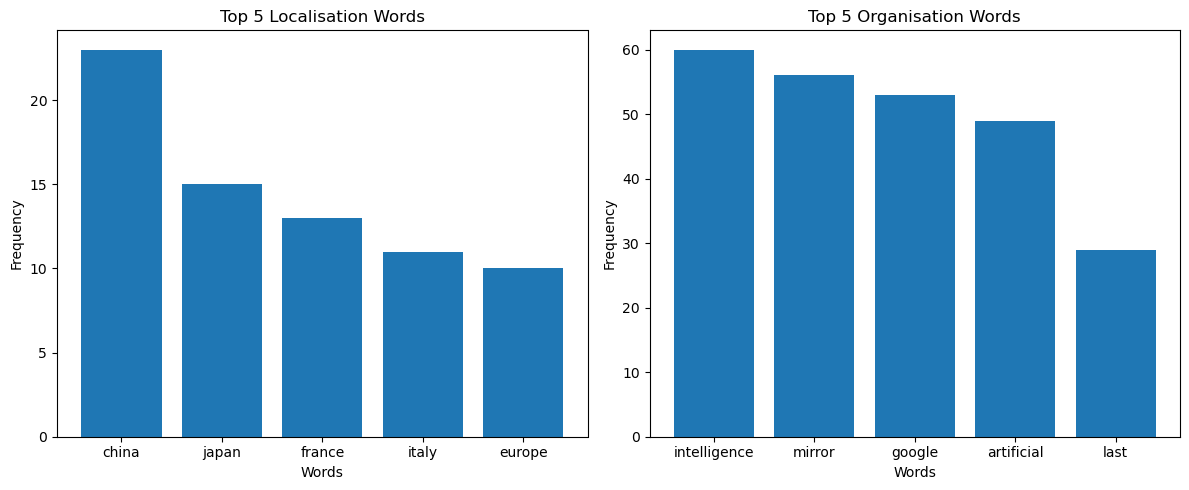

In [27]:
# Plot the 5 most frequent for the localisation
cleaned_dict_loc = {key.lstrip('#'): value for key, value in word_count['LOC'].items()}

# Data Filtering
filtered_dict_loc = {key: value for key, value in cleaned_dict_loc.items() if len(key) > 3}
sorted_dict_loc = dict(sorted(filtered_dict_loc.items(), key=lambda item: item[1], reverse=True)[:5])

# Plot the 5 most frequent for the organisation
cleaned_dict_org = {key.lstrip('#'): value for key, value in word_count['ORG'].items()}

# Data Filtering
filtered_dict_org = {key: value for key, value in cleaned_dict_org.items() if len(key) > 3}
sorted_dict_org = dict(sorted(filtered_dict_org.items(), key=lambda item: item[1], reverse=True)[:5])

# Create a new figure with subplots
plt.figure(figsize=(12, 5))

# Subplot for the Localisation
plt.subplot(1, 2, 1)
plt.bar(sorted_dict_loc.keys(), sorted_dict_loc.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 5 Localisation Words')

# Subplot for the Organisation
plt.subplot(1, 2, 2)
plt.bar(sorted_dict_org.keys(), sorted_dict_org.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 5 Organisation Words')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()